<a href="https://colab.research.google.com/github/prerna-roy/ml_projects/blob/main/malicious_urls_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install opendatasets
import opendatasets as od

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
od.download("https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: prernaroy
Your Kaggle Key: ··········


100%|██████████| 16.9M/16.9M [00:00<00:00, 90.0MB/s]


In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

In [ ]:
df = pd.read_csv("/content/malicious-urls-dataset/malicious_phish.csv")

In [ ]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


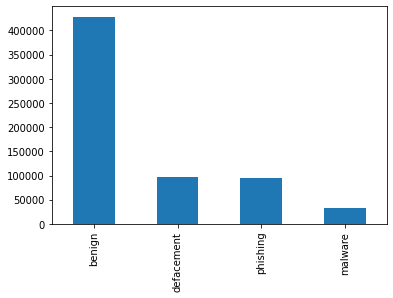

In [ ]:
fig, ax = plt.subplots()
ax = df['type'].value_counts().plot(kind='bar')

In [ ]:
ratio_malicious = round(df['type'][(df['type'] != 'benign')].count() / len(df), 2)
ratio_benign = round(df['type'][(df['type'] == 'benign')].count() / len(df), 2)
print("Proportion of malicious urls =", ratio_malicious)
print("Proportion of benign urls =", ratio_benign)

Proportion of malicious urls = 0.34
Proportion of benign urls = 0.66


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


# **Feature Engineering**
There are clearly not many features in the original dataset to use. Thus feature engineering is conducted to derive useful features from the given URLs. These are extracted in terms of: 
* Address bar features 
* Domain features 

## **Address bar features**
There are many features that can be extracted from the address bar. Of these, these include:
* Domain of URL
* IP address in URL
* Presence of "@" symbol in URL
* Length and depth of URL 
* Redirection attempt in URL (using "//" character) 
* Use of "http" or "https" in domain
* Use of URL shortening 
* Using a prefix/suffic in domain (i.e., use of "-"). 

In [ ]:
## Address bar features extraction libraries 
from urllib.parse import urlparse, urlencode
import ipaddress
import re 

In [ ]:
# For use in finding if URL shortening was used:
#listing shortening services
shortened_urls = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                      r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                      r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                      r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                      r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                      r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
                      r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|" \
                      r"tr\.im|link\.zip\.net"

In [ ]:
# Domain of URL 
def addressBarFeatures(url):

  #Get domain
  def getDomain(url):
    domain = urlparse(url).netloc 
    if re.match(r"www.", domain):
      domain = domain.replace("www.", "")
    return domain 

  #Get IP address
  def hasIP(url):
    try:
      ipaddress.ip_address(url)
      ip = 1
    except:
      ip = 0
    return ip 

  def hasAtSymbol(url):
    if "@" in url:
      at = 1
    else:
      at = 0
    return at

  def urlLength(url):
    length = len(url)
    return length

  def urlDepth(url):
    depth = urlparse(df['url'][100]).path.count('/')
    return depth
    
  def hasRedirection(url):
    if "//" in urlparse(url).path:
      return 1
    else:
      return 0
      
  def domainHTTP(url):
    # checks if http/https is in the domain
    # attempt to fake a scheme inside domain
    if "http" or "https" in urlparse(url).netloc:
      return 1 
    else:
      return 0
  
  def short_url(url):
    match = re.search(shortened_urls, url)
    if match: 
      return 1
    else: 
      return 0
    
  def suffix_prefix(url):
    if '-' in urlparse(url).netloc:
      return 1
    else:
      return 0
      
  return 

# **Domain based features**

Domain based features can be extracted using the 'whois' library. A few common indicators for detecting if a website is malicious or not are:

1. DNS Record 
2. Website Traffic
3. Age of Domain 
4. End of Period of Domain

In [ ]:
# library for extracting domain information 
!pip install python-whois 
import whois
import urllib
import urllib.request 
from bs4 import BeautifulSoup 
from datetime import datetime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def domainFeatures(url):

  def domainName(url):
    w = whois.whois(url)
    return w.domain_name 
  
  def domainAge(url):
    try:
      w = whois.whois(url)
      if type(w.creation_date) == list or type(w.expiration_date) == list:
        createDate, expireDate = w.creation_date[0], w.expiration_date[0]
        domainAge = expireDate - createDate
      else: 
        createDate, expireDate = w.creation_date, w.expiration_date
        domainAge = expireDate - createDate
    except:
      domainAge = None
    return domainAge


  return 

## Testing Feature Extraction [in development]

In [ ]:
for url in df['url'][0:11]:
  try: 
    wi = whois.whois(url)
    if type(wi.creation_date) == list:
      print(wi.creation_date[0])
    else:
      print(wi.creation_date)
  except: 
    pass

None
2000-02-14 03:25:53
2000-01-25 22:48:55
None
2015-02-09 18:46:12
1998-01-09 05:00:00
2005-10-25 18:59:07
2011-02-18 19:37:44
1994-06-02 04:00:00
2007-10-02 18:16:19


In [ ]:
x = whois.whois("http://www.szabadmunkaero.hu/cimoldal.html?start=12")
print(x.domain_name == None)
print(x)

True
{
  "domain_name": null,
  "registrar": null,
  "whois_server": null,
  "referral_url": null,
  "updated_date": null,
  "creation_date": null,
  "expiration_date": null,
  "name_servers": null,
  "status": null,
  "emails": null,
  "dnssec": null,
  "name": null,
  "org": null,
  "address": null,
  "city": null,
  "state": null,
  "registrant_postal_code": null,
  "country": null
}


In [ ]:
w = whois.whois("br-icloud.com.br")
print(w)

{
  "domain_name": null,
  "registrant_name": null,
  "registrant_id": null,
  "country": null,
  "owner_c": null,
  "admin_c": null,
  "tech_c": null,
  "billing_c": null,
  "name_server": null,
  "nsstat": null,
  "nslastaa": null,
  "saci": null,
  "creation_date": null,
  "updated_date": null,
  "expiration_date": null,
  "status": null,
  "nic_hdl_br": null,
  "person": null,
  "email": null
}


In [ ]:
r = whois.whois("bopsecrets.org/rexroth/cr/1.htm")
# print(r.domain_name != None)
# print(r)
print(r)

{
  "domain_name": "bopsecrets.org",
  "registrar": "Network Solutions, LLC",
  "whois_server": "whois.networksolutions.com",
  "referral_url": null,
  "updated_date": "2021-11-26 08:38:03",
  "creation_date": "2000-01-25 22:48:55",
  "expiration_date": "2025-01-25 22:48:55",
  "name_servers": [
    "ns1.firstworld.net",
    "ns2.firstworld.net"
  ],
  "status": "clientTransferProhibited https://icann.org/epp#clientTransferProhibited",
  "emails": [
    "domain.operations@web.com",
    "abuse@web.com"
  ],
  "dnssec": "unsigned",
  "name": [
    "REDACTED FOR PRIVACY",
    "Statutory Masking Enabled"
  ],
  "org": "Statutory Masking Enabled",
  "address": [
    "REDACTED FOR PRIVACY",
    "Statutory Masking Enabled"
  ],
  "city": [
    "REDACTED FOR PRIVACY",
    "Statutory Masking Enabled"
  ],
  "state": "CA",
  "registrant_postal_code": [
    "REDACTED FOR PRIVACY",
    "Statutory Masking Enabled"
  ],
  "country": "US"
}


In [ ]:
for url in df['url']:
  if "//" in urlparse(url).path:
    count = count + 1

print(count)

166


In [ ]:
df[df['type'] == 'phising']

,url,type


In [ ]:
urlparse(df['url'][65]).scheme

'http'

In [ ]:
for url in df['url'][0:50]:
  print(urlparse(url).scheme)

In [ ]:
urlparse(df['url'][0])

ParseResult(scheme='', netloc='', path='br-icloud.com.br', params='', query='', fragment='')

In [ ]:
phish_df = df.loc[df['type'] == 'phishing']